In [1]:
import torch
import cv2
from PIL import Image
import onnxruntime
import numpy as np

import matplotlib.pyplot as plt

from Module.models.Predictor import OnnxPredictor
from Module.models.timm_image_encoder import TimmImageEncoder

C:\Users\danusys\anaconda3\envs\nanosam\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\danusys\anaconda3\envs\nanosam\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
C:\Users\danusys\anaconda3\envs\nanosam\lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
d:\watersegmentation\nanosam\nanosam\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with nanosam.mobile_sam.mo

In [2]:
predictor1 = OnnxPredictor("241107_test_sam_vit-b_encoder.onnx",
                          "sam_onnx_example.onnx")

## image

### Load

(-0.5, 2047.5, 1151.5, -0.5)

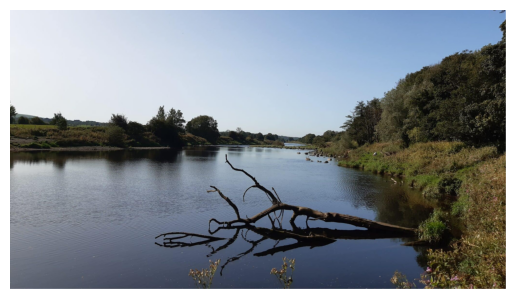

In [22]:
img_path = "../Our-rivers-featured-image-scaled.jpg"
ori_img = cv2.imread(img_path)
ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)

plt.imshow(ori_img)
plt.axis('off')

In [23]:
original_size=ori_img.shape
print(original_size)

(1152, 2048, 3)


In [24]:
binary_mask, embedding1 =predictor1.run(ori_img)

In [25]:
embedding1

[array([[[[-0.04051122, -0.04113192, -0.04680215, ..., -0.04137979,
           -0.03055178, -0.01836452],
          [-0.04120611, -0.0359022 , -0.04378222, ..., -0.04176395,
           -0.03814674, -0.02448786],
          [-0.04144452, -0.03770639, -0.04616675, ..., -0.03989193,
           -0.03750915, -0.04044387],
          ...,
          [ 0.01184091,  0.02480459,  0.01863374, ...,  0.01894975,
            0.02150286,  0.00641212],
          [ 0.01261108,  0.01980574,  0.01615064, ...,  0.02236342,
            0.02602446,  0.00720571],
          [-0.00808689, -0.00357947, -0.00810577, ..., -0.0020809 ,
            0.00169677, -0.01246049]],
 
         [[-0.00107187, -0.0804918 , -0.06644182, ..., -0.09600516,
           -0.05531098, -0.03491139],
          [-0.06561286, -0.14683215, -0.1179615 , ..., -0.13501893,
           -0.16198237, -0.02756345],
          [-0.04082305, -0.12235739, -0.09858561, ..., -0.12008342,
           -0.07902621, -0.05476581],
          ...,
          [-0

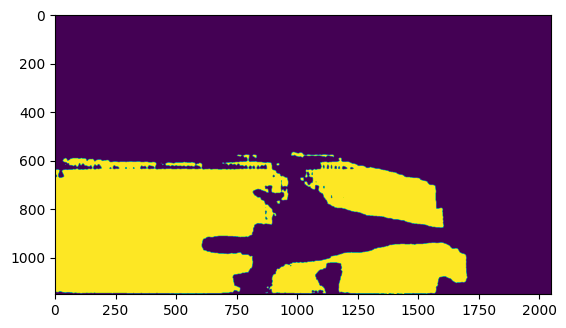

In [26]:
plt.imshow(binary_mask)

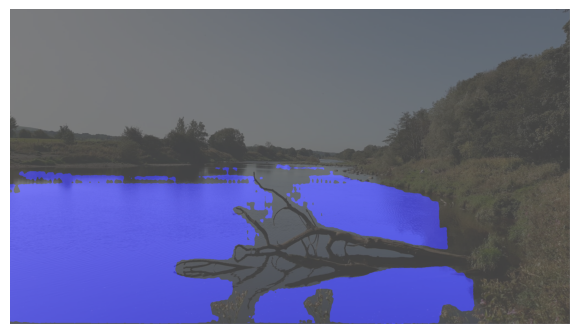

In [27]:
blue_mask = np.zeros_like(binary_mask)
blue_mask[binary_mask == 1] = 1
blue_mask_rgb = np.stack([np.zeros_like(blue_mask),
                          np.zeros_like(blue_mask), 
                          blue_mask], axis=-1)

plt.imshow(ori_img, alpha=0.50)
plt.imshow(blue_mask_rgb, alpha=0.50)
plt.tight_layout()
plt.axis('off');

## Using Original SAM

In [28]:
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.modeling import Sam

In [29]:
dec_model_type = 'vit_b'
dec_checkpoint = './runs/241028_SAM_FT_water_10e/241028_SAM_FT_10e_.pth'

sam_dec = sam_model_registry[dec_model_type](checkpoint=dec_checkpoint)

In [30]:
enc_type = 'resnet18'
enc_checkpoint = "./runs/241031_vit-b_to_resnet18_v2/Nanosam_encoder.pth"
sam_enc = TimmImageEncoder('resnet18', pretrained=True)
sam_enc.load_state_dict(torch.load(enc_checkpoint)["model"])

<All keys matched successfully>

In [31]:
sam_model = Sam(
    image_encoder=sam_enc,
    prompt_encoder=sam_dec.prompt_encoder,
    mask_decoder=sam_dec.mask_decoder
)
predictor2 = SamPredictor(sam_model)

In [32]:
enc_session = onnxruntime.InferenceSession("241107_test_sam_vit-b_encoder.onnx", 
                                           providers=["CPUExecutionProvider"])

In [33]:
dec_session = onnxruntime.InferenceSession("sam_onnx_example.onnx", 
                                           providers=["CPUExecutionProvider"])

In [34]:
predictor2.set_image(ori_img)

In [35]:
image_embedding = predictor2.get_image_embedding().cpu().numpy()


In [36]:
image_embedding

array([[[[-0.03201488, -0.03020523, -0.03895744, ..., -0.04404752,
          -0.02705689, -0.01557462],
         [-0.03424833, -0.02571434, -0.03740104, ..., -0.04754019,
          -0.04191212, -0.02357348],
         [-0.03487219, -0.02818931, -0.04088074, ..., -0.04549605,
          -0.04143596, -0.04043436],
         ...,
         [ 0.00130029,  0.0099877 ,  0.00814153, ...,  0.02735971,
           0.02587527,  0.00906912],
         [ 0.00845258,  0.0189991 ,  0.01560064, ...,  0.03067787,
           0.02866604,  0.00985699],
         [-0.00835344, -0.0022144 , -0.0050373 , ...,  0.00334596,
           0.00318966, -0.01087642]],

        [[-0.00624264, -0.05633226, -0.05197073, ..., -0.08890064,
          -0.03163017, -0.01021788],
         [-0.07985014, -0.12533268, -0.12045653, ..., -0.1126399 ,
          -0.1446636 , -0.00050722],
         [-0.0719116 , -0.11306795, -0.1082157 , ..., -0.11215293,
          -0.07050765, -0.0530103 ],
         ...,
         [-0.09132005, -0.15439697

In [37]:
onnx_coord = np.concatenate([np.array([[0.0, 0.0]])], axis=0)[None, :, :].astype(np.float32)
onnx_label = np.concatenate([np.array([-1])], axis=0)[None, :].astype(np.float32)
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

dec_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(ori_img.shape[:2]).astype(np.float32)
}

In [41]:
masks, _, low_res_logits = dec_session.run(None, dec_inputs)
binary_mask = (masks[0][0, :, :] > 0.0).astype(np.float32)

In [42]:
binary_mask.shape

(1152, 2048)

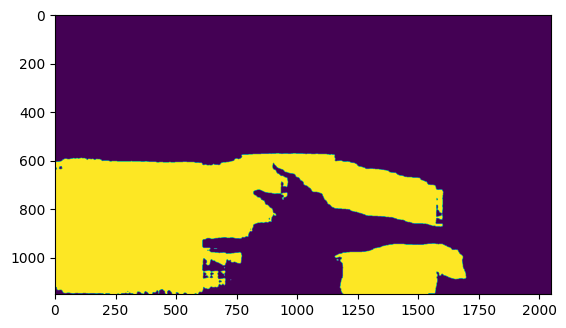

In [43]:
plt.imshow(binary_mask)

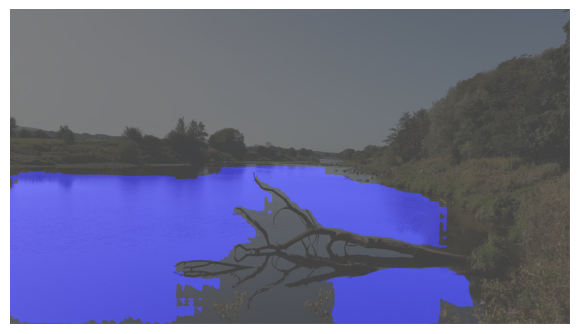

In [21]:
blue_mask = np.zeros_like(binary_mask)
blue_mask[binary_mask == 1] = 1
blue_mask_rgb = np.stack([np.zeros_like(blue_mask),
                          np.zeros_like(blue_mask), 
                          blue_mask], axis=-1)

plt.imshow(ori_img, alpha=0.50)
plt.imshow(blue_mask_rgb, alpha=0.50)
plt.tight_layout()
plt.axis('off');

## Unused

In [24]:
x, _=predictor1.pre_process(ori_img)
predictor1.run_enc(x)

[array([[[[-0.04051122, -0.04113192, -0.04680215, ..., -0.04137979,
           -0.03055178, -0.01836452],
          [-0.04120611, -0.0359022 , -0.04378222, ..., -0.04176395,
           -0.03814674, -0.02448786],
          [-0.04144452, -0.03770639, -0.04616675, ..., -0.03989193,
           -0.03750915, -0.04044387],
          ...,
          [ 0.01184091,  0.02480459,  0.01863374, ...,  0.01894975,
            0.02150286,  0.00641212],
          [ 0.01261108,  0.01980574,  0.01615064, ...,  0.02236342,
            0.02602446,  0.00720571],
          [-0.00808689, -0.00357947, -0.00810577, ..., -0.0020809 ,
            0.00169677, -0.01246049]],
 
         [[-0.00107187, -0.0804918 , -0.06644182, ..., -0.09600516,
           -0.05531098, -0.03491139],
          [-0.06561286, -0.14683215, -0.1179615 , ..., -0.13501893,
           -0.16198237, -0.02756345],
          [-0.04082305, -0.12235739, -0.09858561, ..., -0.12008342,
           -0.07902621, -0.05476581],
          ...,
          [-0

In [25]:
image_embedding

array([[[[-0.03201488, -0.03020523, -0.03895744, ..., -0.04404752,
          -0.02705689, -0.01557462],
         [-0.03424833, -0.02571434, -0.03740104, ..., -0.04754019,
          -0.04191212, -0.02357348],
         [-0.03487219, -0.02818931, -0.04088074, ..., -0.04549605,
          -0.04143596, -0.04043436],
         ...,
         [ 0.00130029,  0.0099877 ,  0.00814153, ...,  0.02735971,
           0.02587527,  0.00906912],
         [ 0.00845258,  0.0189991 ,  0.01560064, ...,  0.03067787,
           0.02866604,  0.00985699],
         [-0.00835344, -0.0022144 , -0.0050373 , ...,  0.00334596,
           0.00318966, -0.01087642]],

        [[-0.00624264, -0.05633226, -0.05197073, ..., -0.08890064,
          -0.03163017, -0.01021788],
         [-0.07985014, -0.12533268, -0.12045653, ..., -0.1126399 ,
          -0.1446636 , -0.00050722],
         [-0.0719116 , -0.11306795, -0.1082157 , ..., -0.11215293,
          -0.07050765, -0.0530103 ],
         ...,
         [-0.09132005, -0.15439697

### pre-processing

In [6]:
def Resize(x, img_size):
    resize = transforms.Resize([img_size, img_size])
    x = Image.fromarray(x)
    x = resize(x)
    return x
    

In [7]:
RLS_transform = ResizeLongestSide(1024)
to_tensor = transforms.ToTensor()

In [8]:
def To_Tensor(x):
    to_tensor = transforms.ToTensor()
    x = torch.as_tensor(x)
    x = x.permute(2, 0, 1).contiguous()[None, :, :, :]
    return x

In [38]:
def normalize(x):
    pixel_mean = torch.Tensor([123.675, 116.28, 103.53]).view(-1, 1, 1)
    pixel_std = torch.Tensor([58.395, 57.12, 57.375]).view(-1, 1, 1)
    
    x = (x - pixel_mean) / pixel_std
    return x

In [39]:
def padding(x):
    enc_size = 1024
    
    h, w = x.shape[-2:]
    padh = enc_size - h
    padw = enc_size- w
    x = F.pad(x, (0, padw, 0, padh))
    return x

In [57]:
img = RLS_transform.apply_image(ori_img)
img.shape

(576, 1024, 3)

In [58]:
img=torch.as_tensor(img)
img = img.permute(2, 0, 1).contiguous()[None, :, :, :]
img.shape

torch.Size([1, 3, 576, 1024])

In [59]:
img=normalize(img)

In [60]:
img=padding(img)

In [61]:
img.shape

torch.Size([1, 3, 1024, 1024])

In [13]:
img = Resize(img, 1024)

In [14]:
img = to_tensor(img)
img.shape

torch.Size([3, 1024, 1024])

In [15]:
img=img.unsqueeze_(0)
img.shape

torch.Size([1, 3, 1024, 1024])

In [65]:
img = normalize(img)
img.shape

torch.Size([1, 3, 1024, 1024])

## Run


### Run Encoder

In [62]:
def to_numpy(tensor):
    return tensor.cpu().numpy()

In [63]:
enc_input = {enc_session.get_inputs()[0].name: to_numpy(img)}
enc_input

{'image': array([[[[ 1.8892884 ,  1.8892884 ,  1.8892884 , ..., -1.5356623 ,
           -0.38830385,  0.65630615],
          [ 1.8892884 ,  1.8892884 ,  1.8892884 , ..., -0.7307989 ,
           -0.02868401,  0.6391814 ],
          [ 1.8892884 ,  1.8892884 ,  1.8892884 , ..., -0.8335474 ,
           -0.28555533,  0.6220566 ],
          ...,
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ]],
 
         [[ 2.1134455 ,  2.1134455 ,  2.1134455 , ..., -1.2303922 ,
            0.04761907,  1.1680672 ],
          [ 2.1134455 ,  2.1134455 ,  2.1134455 , ..., -0.355042  ,
            0.45028013,  1.1855743 ],
          [ 2.1134455 ,  2.1134455 ,  2.1134455 , ..., -0.42507002,
            0.2577031 ,  1.2205883 ],
          ...,
    

In [64]:
image_embedding = enc_session.run(None, enc_input)

### Run Decoder

In [65]:
onnx_coord = np.concatenate([np.array([[0.0, 0.0]])], axis=0)[None, :, :].astype(np.float32)
onnx_label = np.concatenate([np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

In [66]:
dec_inputs = {
    "image_embeddings": image_embedding[0],
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(original_size[:2]).astype(np.float32)
}

In [115]:
masks, _, low_res_logits = dec_session.run(None, dec_inputs)
binary_mask = (masks[0][0, :, :] > -3).astype(np.float32)

## Models

### 